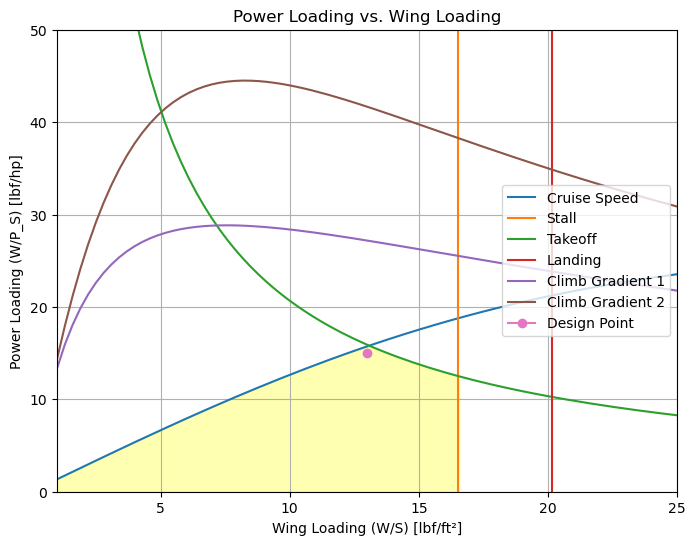

In [28]:
# Metabook pg. 98
# Using A3 for constants

import numpy as math
import matplotlib.pyplot as plt

rho = 0.00238 # slugs/ft^3 - rho is the seal level standard value - Raymer's pg. 131
cL_max_takeoff = 1.7 # CHECK #float(input("Enter the cL_max of the wing: ")) #Needs to be approximated based on historical data
cL_max_cruise = 1.6 # CHECK
cL_max_landing = 1.8 # CHECK
V_stall = 52 * 1.688# ft/s approximation - stall speed of a small aircraft # math.sqrt((2 * W_0) / (rho * S_ref * cL_max)) #float(input("Enter the stall velocity (ft/s): "))

A = 0.74  # Regression constants from Martin's Metabook which cites it from Raymer (2006, Table 3.1)
C = -0.03

s_to = 1500 # RFP #float(input("Enter the takeoff distance (ft): "))
a = 0.0149 
b = 8.134 
discriminant = b**2 - 4*a*(-s_to)
top23 = (-b + math.sqrt(discriminant)) / (2*a)

rho_condition = 0.0023672 # at 200 ft - altitude  #float(input("Enter the air density expected at the field (slug/ft^3): "))
# Metabook pg. 38
# Stating the weight of the payload and crew member
weight_crew = 180  # lbs - from lecture slides
weight_payload = 2000  # lbs - from RFP

Range = 600  # nmi - from RFP "range is the distance flown - use for cruise" lec03
Endurance = 30 / 60  # 30 min -> 0.5 hr from RFP "endurance is the time flown - use for loiter" lec03
c = 0.595  # Updated units for clarity
velocity = 250 * 1.69  # knots to ft/s - maximum operational speed - from RFP

# Initial TOGW Estimate and Iteration Setup
W0 = 19000  # lbs - initial guess for the empty weight
tol = 1e-6  # setting the convergence tolerance
delta = 2 * tol  # setting a value greater than the tolerance for iteration purposes
#list_W0 = []  # creating an empty list to store W0 guesses to plot convergence

# Landing distance - Raymer's text pg. 138
s_a = 600 # ft - from Raymer's text pg. 138
#approach_speed = 1.3 * V_stall # Metabook pg. 38
#landing_time = 45 # float(input("Enter the approximate time it takes for the aircraft to land (s): "))
s_landing = 1500 # in ft

V = 250 * 1.688
v_cruise = V * 0.5
v_inf = v_cruise

AR = 28/3 # NEED TO UPDATE FOR DESIGN 3 ####

W_0 = 6354 # Design 3
S_ref = 336 
c = 1.0447 # Source - Gama
d = 0.5326 # Source - Gama
S_wet = (10 ** c) * (W_0 ** d)

S_wet_S_ref =  S_wet / S_ref
c_f = 0.0055 

parasite_drag_coeff = c_f * S_wet_S_ref

G1 = 0.03 #float(input("Enter the climb gradient of the aircraft during initial climb (G): ")) # G is the climb gradient - ratio between vertical and horizontal distance traveled 
G2 = 0.03 #float(input("Enter the climb gradient of the aircraft during balked landing (G): "))
#Plugging in -G as glide is a climb in the negative direction and setting T/W = 0 
cd_0 = parasite_drag_coeff #+ delta_cD0_landing_flaps + delta_cD0_landing_gear

G3 = 0.083

c_sl = 0.45 # specific fuel consumtion factor in lb / hp-hr # float(input("Enter the value of c_SL: "))  # Algorithm 3 pg. 50 Metabook
S_wet_rest = 1200 # float(input("Enter the wetted area of the aircraft excluding the wings (ft^2): "))  # pg. 49 Metabook


def weight_calc(delta, tol, S0, T_i, W0):
    while (delta > tol):
        We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0
        We = We_W0 * W0
        density_wing = 2.5  # lb/ft^2 Metabook pg. 76
        WS = 12  # design point from W/P vs. W/S diagram from A3
        S_design_point = W0 / WS
        We += density_wing * (S0 - S_design_point)
        T0 = T_i
        W_engine_dp = (750 ** 0.9306) * (10 ** -0.1205) # Metabook 79
        W_engine = 331 #lbs
        We += (W_engine * T0) - (W_engine_dp * T0)

        # Algorithm 3 - fuel fraction calculation
        W1_W0 = 1 - c_sl * (15 / 1) * (0.05 * T0 / W0)  # fuel burned from running the engine for 15 min at 5% max
        W1 = W1_W0 * W0
        W2_W1 = 1 - c_sl * (1 / 1) * (T0 / W1)  # Fuel burned from running the engine for 1 min at max
        W3_W2 = 0.998  # climb segment in Algorithm 3 - using historical values

        c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
        eff_clean = 0.825  # Oswald efficiency factor
        AR = 28/3  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

        CD_0 = c_f * (S_wet_rest + 2 * S0) / S0  # Zero-lift drag coefficient
        k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
        CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
        L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

        W4_W3 = math.exp(-Range * c / (velocity * L_D))  # weight fraction during cruising

        W5_W4 = 0.999  # Descent historical value
        W6_W5 = 0.998  # Landing historical value

        W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
        Wf_W0 = 1 - W6_W0

        W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - We/W0)  # calculating the new takeoff gross weight
        delta = abs((W0_new - W0) / W0_new)
        W0 = W0_new  # updating the takeoff gross weight
        return W0
    

def stall_WS():
    # Stall - Metabook pg. 31 & from lec 07 slide 17
    WS_stall = (1/2) * (rho) * (V_stall)**2 * cL_max_landing
    
    return WS_stall

def takeoff(WS):
    power_weight_ratio_takeoff = WS / ((rho_condition / rho) * cL_max_takeoff * top23)

    return power_weight_ratio_takeoff

def landing_WS():
    WS_landing = ( (s_landing - s_a) / 80 ) * ((rho_condition / rho) * cL_max_landing)

    return WS_landing

def climb(WS):

    V_climb = V_stall * 1.1
    q = 0.5 * rho * (V_climb)**2
    power_weight_ratio_climb1 = ((V_climb/eta_p) * (G3 + (2 * math.sqrt(cd_0 / (AR * math.pi * eff_clean))))) / 550
    power_weight_ratio_climb2 = ((V_climb/eta_p) * (G3 + ((q * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q))))) / 550

    return power_weight_ratio_climb1, power_weight_ratio_climb2

def balked_climb(WS):
    V_balked = V_stall * 1.15
    q = 0.5 * rho * (V_balked)**2
    power_weight_ratio_climb3 = ((V_balked/eta_p) * (G1 + (2 * math.sqrt(cd_0 / (AR * math.pi * eff_clean))))) / 550
    power_weight_ratio_climb4 = ((V_balked/eta_p) * (G1 + ((q * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q))))) / 550

    return power_weight_ratio_climb3, power_weight_ratio_climb4

def ceiling(WS):
    V_ceiling = V * 0.5
    Gceiling = (100 / 60) / V_ceiling
    q = 0.5 * rho * (V_ceiling)**2
    power_weight_ratio_ceiling1 = ((V_ceiling/eta_p) * (Gceiling + (2 * math.sqrt(cd_0 / (AR * math.pi * eff_clean))))) / 550
    power_weight_ratio_ceiling2 = ((V_ceiling/eta_p) * (Gceiling + ((q * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q))))) / 550

    return power_weight_ratio_ceiling1, power_weight_ratio_ceiling2

def maneuver(WS):
    n = 2 # float(input("Enter the load factor (#g): "))
    V_mn = V * 0.5
    q = 0.5 * rho * V_mn**2
    power_weight_ratio_maneuver = ((V_mn/eta_p) * (2 * n * math.sqrt(cd_0 / (AR * math.pi * eff_clean)))) / 550
    power_weight_ratio_maneuver2 = ((V_mn/eta_p) * ((q * cd_0 / WS) + (WS * (n**2) / (AR * math.pi * eff_clean * q)))) / 550

    return power_weight_ratio_maneuver, power_weight_ratio_maneuver2

def cruise(WS):
    v_cruise = V * 0.5
    q_cruise = 0.5 * rho * v_cruise**2
    power_weight_ratio_cruise = ((q_cruise * v_cruise * (cd_0 + ((WS**2)*(0.956**2) / ((q_cruise**2) * math.pi * AR * eff_clean)))) / (550 * eta_p * WS)) / 0.75 # metabook pg. 43

    return power_weight_ratio_cruise

#m_dot = float(input("Enter the mass flow rate of air going through the stream tube (slug/s): "))
#v_jet = float(input("Enter the velocity of air being ejected (ft/s): "))
#v_inf = float(input("Enter the aircraft flying speed (ft/s): "))

# Climb - formulas using from Matabook pg. 41
cL_max_climb = cL_max_takeoff

eff_clean = 0.825

cL_max_cruise = 1.6 
cD_max_cruise = parasite_drag_coeff + (1 / (math.pi * eff_clean * AR)) * (cL_max_cruise ** 2)


#CL = 1.0        # Typical cruise lift coefficient
#CD = 0.02       # Typical cruise drag coefficient

# Efficiency values to compare
#eta_p_values = [0.75, 0.85, 0.95]

eta_p = 0.84
eta_t = 0.6
eta_c = 0.6
eta_g = 0.6

# Wing loading range (W/S) in lbf/ft^2
WS_range = math.linspace(1, 300, 1000)

# Plot W/P vs. W/S
plt.figure(figsize=(8,6))
#for eta_p in eta_p_values:
#WP = eta_p * (cL_max_cruise/cD_max_cruise) * math.sqrt((rho * cL_max_cruise) / (2 * WS_range))
PW_cruise = cruise(WS_range)
PW_takeoff = takeoff(WS_range)
WS_landing = landing_WS() * math.ones(len(WS_range))
climb1, climb2 = climb(WS_range)
climb3, climb4 = balked_climb(WS_range)
SW_stall = stall_WS() * math.ones(len(WS_range))

PW_cruise_s = PW_cruise / eta_p
PW_takeoff_s = PW_takeoff / eta_p
PW_climb2 = climb2 / eta_p
PW_climb4 = climb4 / eta_p

#plt.plot(WS_range, WP, label= "trial1")
plt.plot(WS_range, 1/PW_cruise_s, label=f'Cruise Speed')
plt.plot(SW_stall, math.linspace(0, 300, len(WS_range)), label=f'Stall')
plt.plot(WS_range, 1/PW_takeoff_s, label=f'Takeoff')
plt.plot(WS_landing, math.linspace(0, 300, len(WS_range)), label=f'Landing')
plt.plot(WS_range, 1/(PW_climb2), label=f'Climb Gradient 1')
plt.plot(WS_range, 1/ (PW_climb4), label=f'Climb Gradient 2')
plt.plot(13, 15, label='Design Point', marker = "o")

# Shading the region
y4 = math.minimum((1/PW_cruise_s), (1/PW_takeoff_s))
plt.fill_between((WS_range[:53]), 0, y4[:53], color='yellow', alpha=0.3)

plt.xlim(1, 25)
plt.ylim(0, 50)

# Labels and legend
plt.xlabel("Wing Loading (W/S) [lbf/ft²]")
plt.ylabel("Power Loading (W/P_S) [lbf/hp]")
plt.title("Power Loading vs. Wing Loading")
plt.legend(loc = "right")
plt.grid(True)
plt.show()


#plt.ylim(0, 50)
#plt.xlim(1,40)
#plt.yticks(math.arange(0, 55, step=5))
#plt.xticks(math.arange(2, 41, step=2))
#plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
#plt.tight_layout()
#plt.show()


#thurst = m_dot * (v_jet - v_inf)

#power_available = thurst * v_inf

#eta_p1 = power_available / (power_available + (0.5 * m_dot * (v_jet - v_inf)**2))
#eta_p2 = 2 / (1 + (v_jet / v_inf))


1042.6856214693403


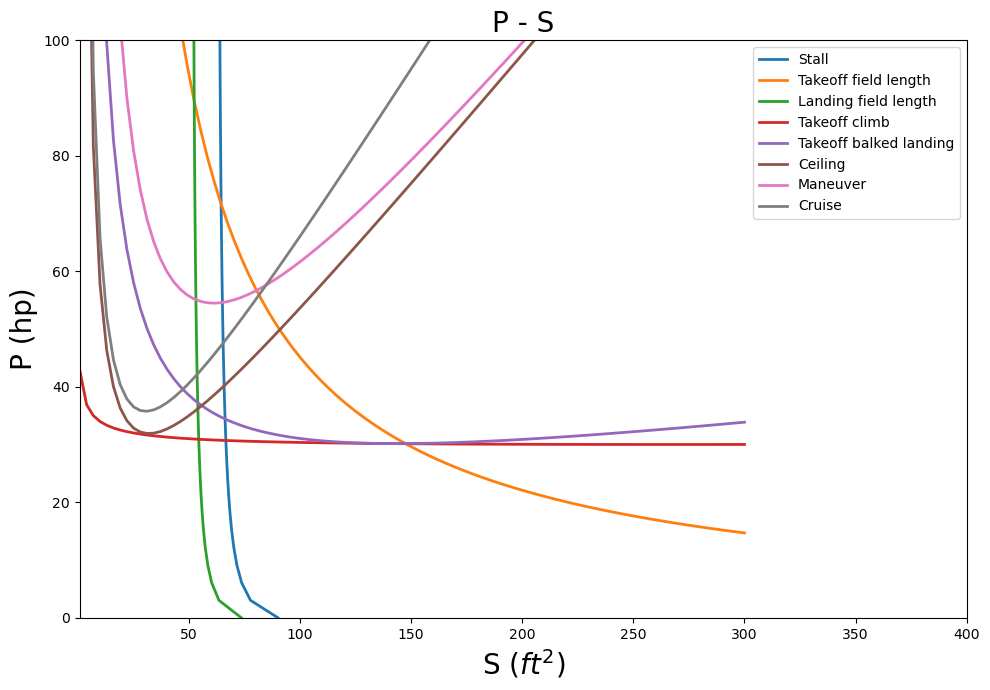

In [ ]:
###############################
#### PART 2 #####

S = math.linspace(1, 300, 100)  # Wing area range
#T = math.linspace(1, 1000, 100)  # Thrust range
eta_p = 0.60  # Assumed propeller efficiency

W_engine = 13500 # CHECK float(input("Enter the weight of the engine (lbs): "))
W_engine_dp = 12000 # CHECK float(input("Enter the weight of the engine at the design point (lbs): "))

mu = 3.737 * (10 ** -7)
rho = 0.0023769  # Air density (slug/ft³)
Re = (rho * velocity * 3) / mu  # chord length is taken to be 3

P = math.ones(len(S))
WS_stall = math.ones(len(S))
PW_new_takeoff = math.ones(len(S))
WS_landing = math.ones(len(S))
PW_climb1 = math.ones(len(S))
PW_climb2 = math.ones(len(S))
PW_ceiling1 = math.ones(len(S))
PW_ceiling2 = math.ones(len(S))
PW_balked_climb1 = math.ones(len(S))
PW_balked_climb2 = math.ones(len(S))
PW_maneuver1 = math.ones(len(S))
PW_maneuver2 = math.ones(len(S))
PW_cruise = math.ones(len(S))
S_stall = math.ones(len(S))
P_takeoff = math.ones(len(S))
S_landing = math.ones(len(S))
P_climb1 = math.ones(len(S))
P_climb2 = math.ones(len(S))
P_balked_climb1 = math.ones(len(S))
P_balked_climb2 = math.ones(len(S))
P_ceiling1 = math.ones(len(S))
P_ceiling2 = math.ones(len(S))
P_maneuver1 = math.ones(len(S))
P_maneuver2 = math.ones(len(S))
P_cruise = math.ones(len(S))

# Metabook Algorithm 2 pg. 49
for i in range(len(S)):
    tol = 1e-6  # setting the convergence tolerance
    delta = 2 * tol  # setting a value greater than the tolerance for iteration purposes
    S0 = S[i]
    P[i] = 100 # guessed value
    #list_W0.append(W0)  # adding the current value of W0 to the list
    converged = False
    while (converged == False):
        WP = 19  # design point from W/P vs. W/S diagram from A3
        P0 = W0 / WP
        T_i = P0 * (550 * eta_p / velocity)
        W0_initial = 19000
        W = weight_calc(delta, tol, S0, T_i, W0_initial)
        WS0 = W / S0
        WS_stall[i] = stall_WS()
        S_stall[i] = W / WS_stall[i]
        PW_new_takeoff[i] = takeoff(WS0)
        P_takeoff[i] = W * PW_new_takeoff[i]
        WS_landing[i] = landing_WS()
        S_landing[i] = W / WS_landing[i]
        PW_climb1[i], PW_climb2[i] = climb(WS0)
        P_climb1[i] = W * PW_climb1[i]
        P_climb2[i] = W * PW_climb2[i]
        PW_balked_climb1[i], PW_balked_climb2[i] = balked_climb(WS0)
        P_balked_climb1[i] = W * PW_balked_climb1[i]
        P_balked_climb2[i] = W * PW_balked_climb2[i]
        PW_ceiling1[i], PW_ceiling2[i] = ceiling(WS0)
        P_ceiling1[i] = W * PW_ceiling1[i]
        P_ceiling2[i] = W * PW_ceiling2[i]
        PW_maneuver1[i], PW_maneuver2[i] = maneuver(WS0)
        P_maneuver1[i] = W * PW_maneuver1[i]
        P_maneuver2[i] = W * PW_maneuver2[i]
        PW_cruise[i] = cruise(WS0)
        P_cruise[i] = W * PW_cruise[i]
        if (abs(PW_new_takeoff[i] - P[i]) <= tol):
            converged = True
            break
        P[i] = PW_new_takeoff[i]

print(W)


plt.figure(figsize=(10,7))
plt.title('P - S', fontsize=20)
plt.xlabel("S $(ft^2)$", fontsize=20)
plt.ylabel("P (hp)", fontsize=20)
plt.plot(S_stall, math.linspace(0,300,len(S_stall)), label='Stall', linestyle='-', linewidth=2)
plt.plot(S, (P_takeoff), label='Takeoff field length', linestyle='-', linewidth=2)
plt.plot(S_landing, math.linspace(0,300,len(S_stall)), label='Landing field length', linestyle='-', linewidth=2)
#plt.plot(WS, (1/power_weight_ratio_climb_takeoff1), label='Takeoff climb min', linestyle='-', linewidth=2)
plt.plot(S, (P_climb1), label='Takeoff climb ', linestyle='-', linewidth=2)
#plt.plot(WS, (1/power_weight_ratio_climb_takeoff3), label='Takeoff balked landing min', linestyle='-', linewidth=2)
plt.plot(S, (P_climb2), label='Takeoff balked landing', linestyle='-', linewidth=2)
#plt.plot(WS, (1/power_weight_ratio_ceiling1), label='Ceiling Min', linestyle='-', linewidth=2)
plt.plot(S, (P_ceiling2), label='Ceiling', linestyle='-', linewidth=2)
#plt.plot(WS, (1/power_weight_ratio_maneuver), label='Maneuver Min', linestyle='-', linewidth=2)
plt.plot(S, (P_maneuver2), label='Maneuver', linestyle='-', linewidth=2)
plt.plot(S, (P_cruise), label='Cruise', linestyle='-', linewidth=2)
#plt.plot(S_Ipanema, power_loading_Ipanema, label='Ipanema', marker="o")
#plt.plot(WS_AT502B, power_loading_AT502B, label='AT502B', marker="o")
#plt.plot(WS_AT602, power_loading_AT602, label='AT602', marker="o")

# Shading the region
#y4 = math.minimum((1/power_weight_ratio_cruise), (1/power_weight_ratio_takeoff))
#plt.fill_between((WS[:42]), 0, y4[:42], color='yellow', alpha=0.3)

plt.ylim(0, 100)
plt.xlim(1,400)
#plt.yticks(math.arange(0, 55, step=5))
#plt.xticks(math.arange(2, 41, step=2))
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


# We = We_W0 * W0

#print(f"Final Takeoff Gross Weight (TOGW): {float(W0):.2f} lbs")
#print(f"Final Empty Weight (We): {float(We):.2f} lbs")
